# Metrics and Analysis

In this notebook, we compare the results of different metrics after style transfer both on clear and encrypted data. For image style transfer, we found found two most suitable metrics - **Structural Similarity Index Metrics (SSIM)** and **Learned Perceptual Image Patch Similarity (LPIPS)**. After computing both the metrics for results on clear and encrypted data, we found that our FHE-compatible style-transfer model performed almost similar to pre-trained style-transfer model with **5-bits post-quantization**. Rest of the notebook describes the metrics and compares corresponding results on both clear and encrypted images


## Structural Similarity Index Metrics (SSIM)

 **Structural Similarity Index Metrics (SSIM)** is based on the **degradation of structural information** and for its computation it takes into account:
  1. Luminance
  2. Contrast
  3. Structure

The **Structural Similarity Index Metrics(SSIM)** score is given by:

  $SSIM(x,y) = \frac{(2\mu_x.\mu_y\;+\;c_1)(2\sigma_{xy}\;+\;c_2)}{(\mu_x^{2}\;+\;\mu_y^{2}\;+\;c_1)(\sigma_x^2\;+\;\sigma_y^2\;+\;\sigma_z^2\;+\;c_2)}$

$\mu_{x},\mu_{y}:$ Pixel Sample Means of styled and original image

$\sigma_x,\sigma_y:$ Pixel Standard Deviation of styled and original image

$\sigma_{xy}:$ Covariance of styled and original image

$c_1,c_2:$ Constants for preventing from denominator from becoming zero


So, we expect the SSIM score is not very close to **1 (original Image)**, and it  also shouldn't be very close to **0 (completly different Image)**. This is the condition that we fix for a smooth **Style Transfer**.

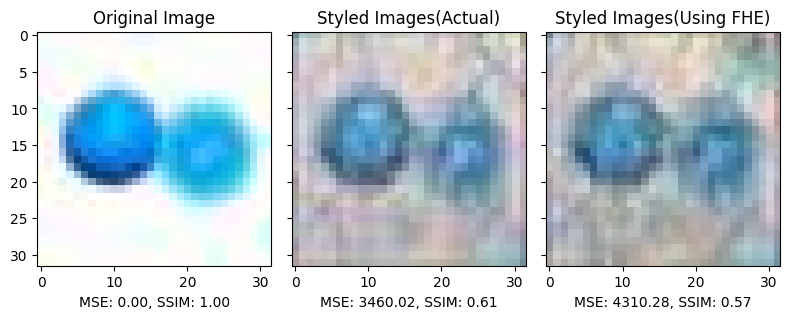

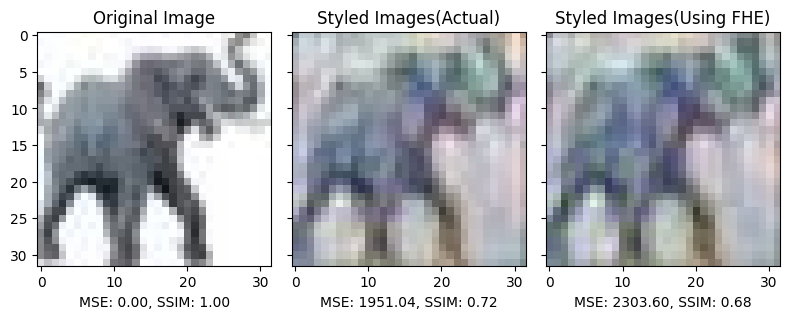

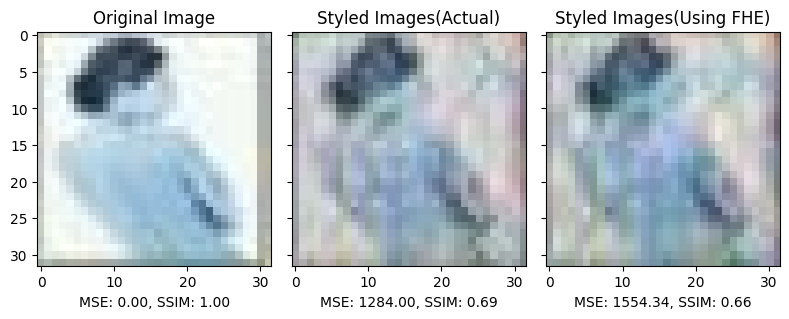

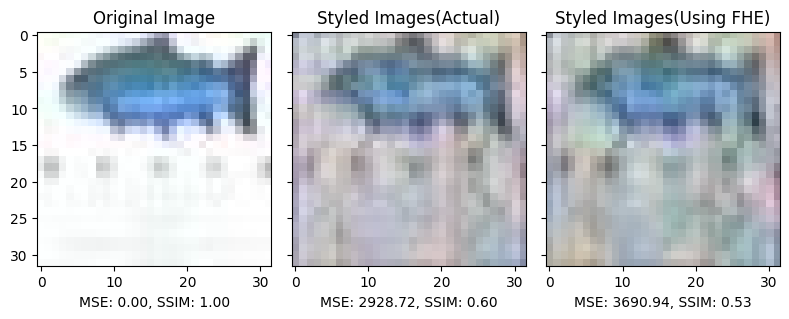

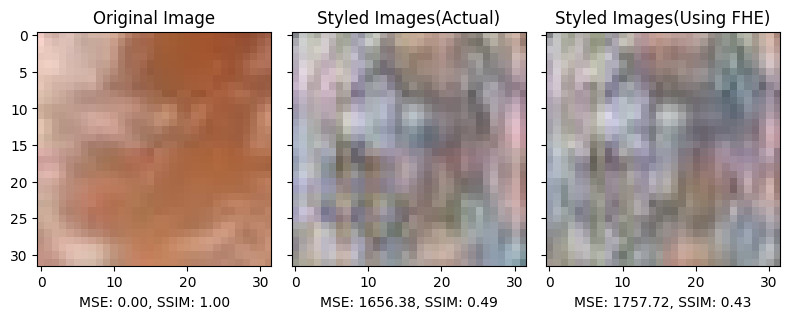

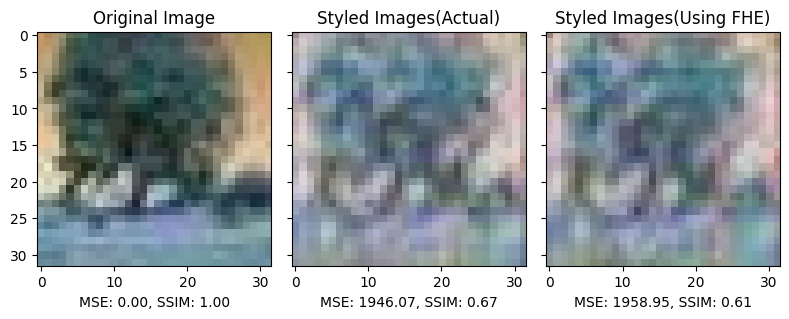

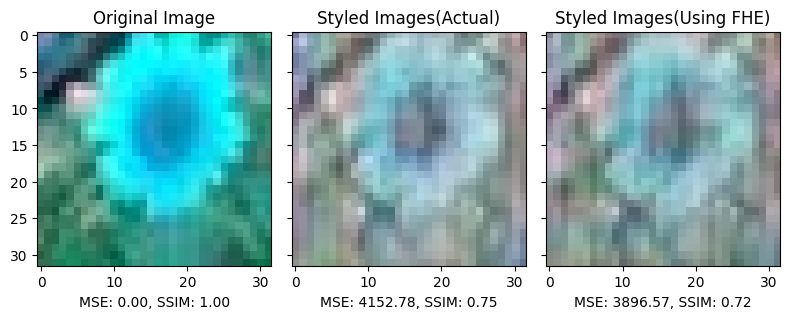

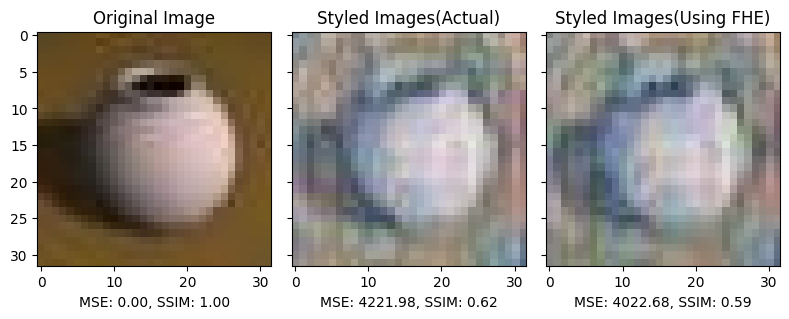

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# img_noise = cv2.imread('/content/mosiac-small.jpg')
img_list = ['632.jpg', '10.jpg', '6327.jpg', '59801.jpg', '59665.jpg', '59689.jpg', '59776.jpg', '59796.jpg']

for id in range(8):
  fn = img_list[id].split('/')[-1].split('.')[0]
  img = cv2.imread('./cifar-dataset/cifar100/'+img_list[id])
  img_encrypted = cv2.imread(f'./results/private-{img_list[id]}')
  img_original = cv2.imread(f'./results/{fn}-output.jpg')
  rows, cols,_ = img.shape

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4), sharex=True, sharey=True)
  ax = axes.ravel()

  mse_none = mean_squared_error(img, img)
  ssim_none = ssim(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), data_range=img.max() - img.min())

  mse_original = mean_squared_error(img, img_original)
  ssim_original = ssim(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), cv2.cvtColor(img_original,cv2.COLOR_BGR2GRAY), data_range=img_original.max() - img_original.min())

  mse_const = mean_squared_error(img, img_encrypted)
  ssim_const = ssim(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), cv2.cvtColor(img_encrypted,cv2.COLOR_BGR2GRAY), data_range=img_encrypted.max() - img_encrypted.min())

  ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
  ax[0].set_title('Original Image')

  ax[1].imshow(img_original, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax[1].set_xlabel(f'MSE: {mse_original:.2f}, SSIM: {ssim_original:.2f}')
  ax[1].set_title('Styled Images(Actual)')

  ax[2].imshow(img_encrypted, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax[2].set_xlabel(f'MSE: {mse_const:.2f}, SSIM: {ssim_const:.2f}')
  ax[2].set_title('Styled Images(Using FHE)')

  plt.tight_layout()
  plt.show()

 As, we obeserve the **SSIM-score** is neither close to **1** nor close to **0** in all the case, so we can consider a smooth style tranfers for all the 8 images. We, also observe similar results (**MSE** and **SSIM**) for both clear and encrypted images. Also, the MSE for images with encryption, is somewhat higher, which suggest more structural changes w.r.t the original images. The ouput for clear images are better than the ones with encryption, as suggested by both **MSE** & **SSIM**.

## Learned Perceptual Image Patch Similarity (LPIPS)

The **Learned Perceptual Similarity metric (LPIPS)** works by
extracting and comparing features from pre-trained neural
networks, shown to model low-level perceptual similarity
particularly well. We use this metrics to proof our hypothesis that, the original and styled images are similar and not very different. The smaller the loss value, the more the images are similar. For, Style transfer we expect the **LPIPS-score** to be small as ~0.1.

In [97]:
!pip install lpips -q
import lpips
import torch
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


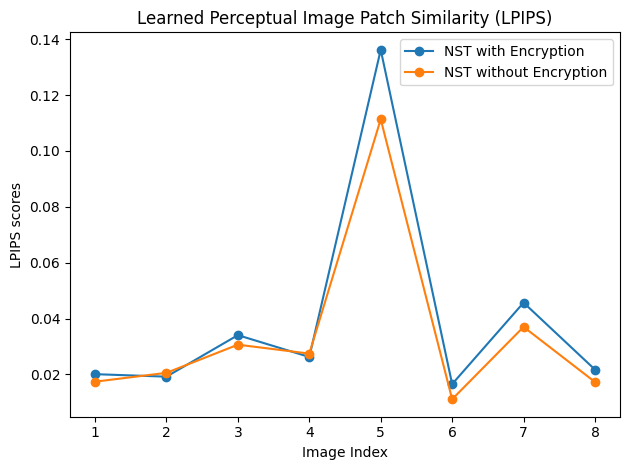

In [110]:
lpips_scores_encrypted = []
lpips_scores_original = []

for id in range(len(img_list_original)):

  img = cv2.cvtColor(cv2.imread('style-transfer-results/'+imag_list[id]), cv2.COLOR_BGR2GRAY)
  img_const = cv2.cvtColor(cv2.imread('style-transfer-results/'+imag_list[id+8]), cv2.COLOR_BGR2GRAY)
  img_original = cv2.cvtColor(cv2.imread('style_original/'+img_list_original[id]), cv2.COLOR_BGR2GRAY)

  img0 = torch.from_numpy(img.astype('float32'))
  img1 = torch.from_numpy(img_const.astype('float32'))
  img2 = torch.from_numpy(img_original.astype('float32'))

  d = loss_fn_alex(img0,img1)
  d1 = loss_fn_alex(img0,img2)
  lpips_scores_encrypted.append(d.item())
  lpips_scores_original.append(d1.item())

## plot the results
plt.plot(np.arange(1,9,1),lpips_scores_encrypted,marker = 'o')
plt.plot(np.arange(1,9,1),lpips_scores_original,marker = 'o')
plt.xlabel('Image Index')
plt.ylabel('LPIPS scores')
plt.title('Learned Perceptual Image Patch Similarity (LPIPS)')
plt.legend(['NST with Encryption','NST without Encryption'])
plt.tight_layout()
plt.show()

As, we see that both the clear and encrypted images are showing lower values of **LPIPS-score**, which is shows structure of the image has not changed much after style transfer. In fact,the images without encryption are giving better results as per our Hypothesis. We, see a similar **LPIPS-score** for all the images,except $5^{th}$ image. We can consider the it as an anomaly, maybe the structural aspect in the image has change little more, but still its a valid Style Transfer. These issues might be occuring due to edge effect because of the specific padding sequence(constant instead of reflection) used while training.